In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import keras
import tensorflow as tf
from keras import backend as K
from keras.layers import Conv2D, MaxPool2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten
from keras.callbacks import EarlyStopping 
from keras.preprocessing.image import ImageDataGenerator

import cv2
import time
import csv

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
#  Loading the data 
train_csv = pd.read_csv('/kaggle/input/planets-dataset/planet/planet/train_classes.csv')
sample_submission = pd.read_csv('/kaggle/input/planets-dataset/planet/planet/sample_submission.csv')
train_jpg_directory = '/kaggle/input/planets-dataset/planet/planet/train-jpg'
test_jpg_directrory = '/kaggle/input/planets-dataset/planet/planet/test-jpg'

In [3]:
train_csv

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
...,...,...
40474,train_40474,clear primary
40475,train_40475,cloudy
40476,train_40476,agriculture clear primary
40477,train_40477,agriculture clear primary road


In [4]:
count = {}
split_tags = train_csv['tags'].map(lambda x: x.split(' '))

for labels in split_tags.values:
    for label in labels:
        count[label] = count[label] + 1  if label in count else 0    

labels = list(count.keys())
print(labels)
print(count)

['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation', 'road', 'cultivation', 'slash_burn', 'cloudy', 'partly_cloudy', 'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming', 'selective_logging', 'blow_down']
{'haze': 2696, 'primary': 37512, 'agriculture': 12314, 'clear': 28430, 'water': 7410, 'habitation': 3659, 'road': 8070, 'cultivation': 4546, 'slash_burn': 208, 'cloudy': 2088, 'partly_cloudy': 7260, 'conventional_mine': 99, 'bare_ground': 861, 'artisinal_mine': 338, 'blooming': 331, 'selective_logging': 339, 'blow_down': 100}


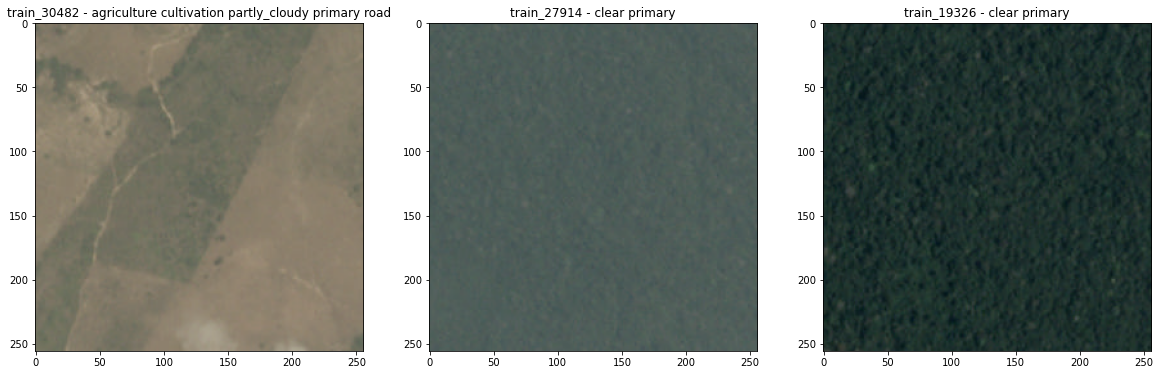

In [5]:
_, ax = plt.subplots(1, 3, figsize=(20, 20))

random_img = np.random.randint(0,len(train_csv), size=3)

for i , (file, label) in enumerate(train_csv.iloc[random_img].values):
    img = cv2.imread(f'/kaggle/input/planets-dataset/planet/planet/train-jpg/{file}.jpg')
    ax[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[i].set_title('{} - {}'.format(file, label))
    
plt.show()

In [6]:
image = cv2.imread('/kaggle/input/planets-dataset/planet/planet/train-jpg/train_0.jpg')
height, width, channels = image.shape
print("Image Width:", width)
print("Image Height:", height)

Image Width: 256
Image Height: 256


In [7]:
train_csv_copy = train_csv.copy()
for tag in labels:
    train_csv_copy[tag] = train_csv_copy['tags'].apply(lambda x: 1 if tag in x.split() else 0)

train_csv_copy['image_name'] = train_csv_copy['image_name'].apply(lambda x: f'{x}.jpg')    
train_csv_copy.set_index('image_name')

,tags,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
image_name,,,,,,,,,,,,,,,,,,
train_0.jpg,haze primary,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
train_1.jpg,agriculture clear primary water,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
train_2.jpg,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
train_3.jpg,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
train_4.jpg,agriculture clear habitation primary road,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
train_40474.jpg,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
train_40475.jpg,cloudy,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
train_40476.jpg,agriculture clear primary,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
train_datagen = ImageDataGenerator(rescale = 1/255, validation_split = 0.2)

train_generator = train_datagen.flow_from_dataframe(dataframe=train_csv_copy,
                                                    directory = train_jpg_directory, 
                                                    x_col='image_name', y_col = labels, subset='training', 
                                                    batch_size = 32,seed = 42, shuffle = True, 
                                                    class_mode='raw', target_size=(128, 128))

val_generator = train_datagen.flow_from_dataframe(dataframe = train_csv_copy,
                                                  directory = train_jpg_directory, 
                                                  x_col = 'image_name', y_col = labels, subset = 'validation', 
                                                  batch_size = 32,seed = 42, shuffle = True, 
                                                  class_mode = 'raw', target_size = (128, 128))

Found 32384 validated image filenames.
Found 8095 validated image filenames.


In [9]:
step_train_size = int(np.ceil(train_generator.samples / train_generator.batch_size))
step_val_size = int(np.ceil(val_generator.samples / val_generator.batch_size))
print(step_train_size, step_val_size)

1012 253


In [10]:
def cnn_model():
    model = Sequential()

    # Convolution layers
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(128, 128, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten layer
    model.add(Flatten())

    # Fully connected layers
    model.add(Dense(units=512, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=17, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer=Adam(lr=0.001), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    return model

In [11]:
model = cnn_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 256)       2

In [12]:
# Create Early Stopping Callback to monitor the accuracy
early_stopping_callback = EarlyStopping(monitor = 'val_accuracy', patience = 10, restore_best_weights = True)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.6,
                                                  patience=5,
                                                  min_lr=0.00005,
                                                  verbose=1)

In [13]:
# Fit the model 
model_history = model.fit(x = train_generator, 
                    steps_per_epoch = step_train_size, 
                    validation_data = val_generator,
                    validation_steps = step_val_size,
                    epochs = 20, 
                    shuffle = True,
                    callbacks = [early_stopping_callback, reduce_lr])

Epoch 1/20
1012/1012 [==============================] - 222s 219ms/step - loss: 0.2083 - accuracy: 0.8520 - val_loss: 0.1571 - val_accuracy: 0.8705 - lr: 0.0010
Epoch 2/20
1012/1012 [==============================] - 114s 113ms/step - loss: 0.1604 - accuracy: 0.7881 - val_loss: 0.1458 - val_accuracy: 0.8325 - lr: 0.0010
Epoch 3/20
1012/1012 [==============================] - 116s 114ms/step - loss: 0.1484 - accuracy: 0.7365 - val_loss: 0.1448 - val_accuracy: 0.7075 - lr: 0.0010
Epoch 4/20
1012/1012 [==============================] - 115s 114ms/step - loss: 0.1419 - accuracy: 0.7430 - val_loss: 0.1361 - val_accuracy: 0.8098 - lr: 0.0010
Epoch 5/20
1012/1012 [==============================] - 115s 113ms/step - loss: 0.1365 - accuracy: 0.7208 - val_loss: 0.1296 - val_accuracy: 0.7692 - lr: 0.0010
Epoch 6/20
1012/1012 [==============================] - 115s 113ms/step - loss: 0.1313 - accuracy: 0.7137 - val_loss: 0.1282 - val_accuracy: 0.7910 - lr: 0.0010
Epoch 7/20
1012/1012 [============

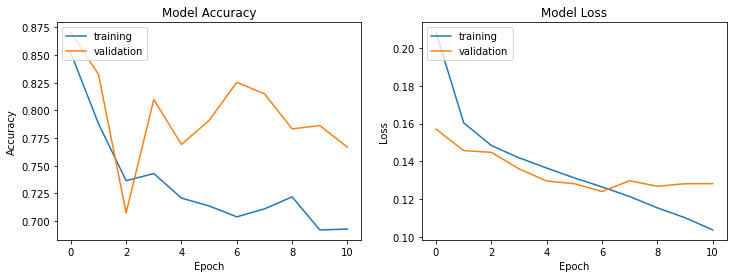

In [14]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper left')

plt.show()

In [15]:
sample_submission

,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water
...,...,...
61186,file_9995,primary clear agriculture road water
61187,file_9996,primary clear agriculture road water
61188,file_9997,primary clear agriculture road water
61189,file_9998,primary clear agriculture road water


In [16]:
test_csv = sample_submission.iloc[:40669]['image_name'].reset_index().drop('index', axis = 1)
test_csv['image_name'] = test_csv['image_name'].apply(lambda x: f'{x}.jpg')   
test_csv

,image_name
0,test_0.jpg
1,test_1.jpg
2,test_2.jpg
3,test_3.jpg
4,test_4.jpg
...,...
40664,test_40664.jpg
40665,test_40665.jpg
40666,test_40666.jpg
40667,test_40667.jpg


In [17]:
test_datagen = ImageDataGenerator(rescale = 1/255)

test_gen = test_datagen.flow_from_dataframe(dataframe=test_csv, 
                                            directory='/kaggle/input/planets-dataset/planet/planet/test-jpg/', 
                                            x_col="image_name", 
                                            y_col=None, 
                                            batch_size=32,
                                            seed=42,
                                            shuffle=False, 
                                            class_mode=None, 
                                            target_size=(128,128))

step_test_size = int(np.ceil(test_gen.samples/test_gen.batch_size))

Found 40669 validated image filenames.


In [18]:
test_gen.reset()
predictions = model.predict(test_gen, steps=step_test_size, verbose=1)

1271/1271 [==============================] - 231s 182ms/step


In [19]:
file_names = test_gen.filenames

# Convert the predicted values to a dataframe and join two labels together if prob(occurrance of the label) > 0.5 
prediction_tags = pd.DataFrame(predictions)
prediction_tags = prediction_tags.apply(lambda x: ' '.join(np.array(labels)[x > 0.5]), axis = 1)

test_results = pd.DataFrame({'image_name': file_names, 'tags': prediction_tags})
test_results.head()

,image_name,tags
0,test_0.jpg,primary clear
1,test_1.jpg,primary clear
2,test_2.jpg,primary partly_cloudy
3,test_3.jpg,primary clear
4,test_4.jpg,primary partly_cloudy


In [20]:
additional_test_df = sample_submission.iloc[40669:]['image_name'].reset_index().drop('index', axis =1)
additional_test_df['image_name'] = additional_test_df['image_name'].apply(lambda x: f'{x}.jpg')  
additional_test_df

,image_name
0,file_0.jpg
1,file_1.jpg
2,file_10.jpg
3,file_100.jpg
4,file_1000.jpg
...,...
20517,file_9995.jpg
20518,file_9996.jpg
20519,file_9997.jpg
20520,file_9998.jpg


In [21]:
#creating a generator for the second batch of test image files
test_gen_additional = test_datagen.flow_from_dataframe(dataframe = additional_test_df, 
                                                directory = '../input/planets-dataset/test-jpg-additional/test-jpg-additional', 
                                                x_col = 'image_name', 
                                                y_col = None, 
                                                batch_size = 32, 
                                                shuffle = False, 
                                                class_mode = None, 
                                                target_size = (128,128))

step_test_size_additional = int(np.ceil(test_gen_additional.samples / test_gen_additional.batch_size))

Found 20522 validated image filenames.


In [22]:
test_gen_additional.reset()
predictions_additional = model.predict(test_gen_additional, steps = step_test_size_additional, verbose = 1)

642/642 [==============================] - 118s 184ms/step


In [23]:
file_names = test_gen_additional.filenames

predictions_additional = pd.DataFrame(predictions_additional)
predictions_additional = predictions_additional.apply(lambda x: ' '.join(np.array(labels)[x>0.5]), axis = 1)

test_results_additional = pd.DataFrame({'image_name': file_names, 'tags': predictions_additional})
test_results_additional

,image_name,tags
0,file_0.jpg,primary clear
1,file_1.jpg,primary agriculture clear road
2,file_10.jpg,cloudy
3,file_100.jpg,primary clear
4,file_1000.jpg,primary clear
...,...,...
20517,file_9995.jpg,primary partly_cloudy
20518,file_9996.jpg,primary agriculture clear
20519,file_9997.jpg,primary clear
20520,file_9998.jpg,cloudy


In [24]:
submission_df = pd.concat([test_results, test_results_additional])
submission_df = submission_df.reset_index().drop('index', axis = 1)
submission_df

,image_name,tags
0,test_0.jpg,primary clear
1,test_1.jpg,primary clear
2,test_2.jpg,primary partly_cloudy
3,test_3.jpg,primary clear
4,test_4.jpg,primary partly_cloudy
...,...,...
61186,file_9995.jpg,primary partly_cloudy
61187,file_9996.jpg,primary agriculture clear
61188,file_9997.jpg,primary clear
61189,file_9998.jpg,cloudy


In [25]:
submission_df['image_name'] = submission_df['image_name'].apply(lambda x: x[:-4])
submission_df

,image_name,tags
0,test_0,primary clear
1,test_1,primary clear
2,test_2,primary partly_cloudy
3,test_3,primary clear
4,test_4,primary partly_cloudy
...,...,...
61186,file_9995,primary partly_cloudy
61187,file_9996,primary agriculture clear
61188,file_9997,primary clear
61189,file_9998,cloudy


In [26]:
submission_df.to_csv('submission.csv', index = False)